In [ ]:
import cv2
import json
import os
import shutil
import torch
import youtube_dl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import unicode_literals
from sklearn.model_selection import train_test_split

In [2]:
# blow out the bbox into max.min values
def expand_bbox_coords(bbox):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[0] + bbox[2]
    ymax = bbox[1] + bbox[3]

    return (xmin, ymin, xmax, ymax)


def obtain_bbox_label(categories, bbox_tag):
    
    label = categories[categories['id']==bbox_tag['category_id']]['name'].item()
    label = str(label)

    return (label)


def coco_to_dict(img, annots_df):

    # obtain relevant image data
    img_name = os.path.basename(img['file_name'])
    img_size = (img['width'], img['height'], 3)
    
    # cut to relevant bbox annotations
    img_id = img['id']
    tags = annots_df[annots_df['image_id']==img_id]

    # iterate through bbox annotations
    bboxes = []
    for _, tag in tags.iterrows():
        bbox_annot = {
            'label': tag['category_id'],
            'xmin': tag['xmin'],
            'ymin': tag['ymin'],
            'xmax': tag['xmax'],
            'ymax': tag['ymax']
        }
        bboxes.append(bbox_annot)
       
    img_dict = {
        'bboxes': bboxes,
        'image_name': img_name,
        'image_size': img_size
    }
    
    return img_dict


def dict_to_yolo(img_dict):
    img_name = img_dict['image_name']
    img_width, img_height, img_depth = img_dict['image_size']

    annot_txt =[]
    for box in img_dict['bboxes']:

        # extract abs bbox info
        lbl = box['label']
        x_centre = (box['xmin'] + box['xmax']) / 2
        y_centre = (box['ymin'] + box['ymax']) / 2
        width = box['xmax'] - box['xmin']
        height = box['ymax'] - box['ymin']

        # convert bbx infor to rel
        x_centre = round(x_centre / img_width, 3)
        y_centre = round(y_centre / img_height, 3)
        width = round(width / img_width, 3)
        height = round(height / img_height, 3)

        annot_txt.append(" ".join([
            str(lbl), str(x_centre), str(y_centre), str(width), str(height)
            ]))

    annot_name = os.path.splitext(img_name)[0] + '.txt'
        

    return annot_name, annot_txt



def copy_files(list_img, list_annot, split, output_base):

    # copy the images over
    img_folder = os.path.join(output_base, 'images', split)
    if not os.path.isdir(img_folder):
        os.makedirs(img_folder)

    for x in list_img:
        shutil.copy(x, img_folder)

    # copy the annotation files over
    annot_folder = os.path.join(output_base, 'labels', split)
    if not os.path.isdir(annot_folder):
        os.makedirs(annot_folder)

    for x in list_annot:
        shutil.copy(x, annot_folder)
    
    return 

### Annotating Images

The fist step is to obtain a dataset of suitably annotated images on which to train the model. For the purpose of object detection it is important to ensure that the annotation data is fine-grained - contains class label and coordinate location of associated bboxes. 

While there are various open source datasets containing annotated logo data for some of the biggest brands, in order to show how this could be applied to a specific use case, I chose to manually label a specific brand using the free labelling software "Label Studio"

The brand I selected was Petronas which are major sponsors of Mercedes F1 team - with the outputs of my manual labelling found in "data/Label_Studio_Output". 

It is worth noting that Label Studio enables annotation data to be exported into various different formats - e.g. Pascal VOC, COCO, CSV, COCO - if you are not familair with the different formats I recommend the following aritcle: https://www.edge-ai-vision.com/2022/04/exploring-data-labeling-and-the-6-different-types-of-image-annotation/

In order to export a single  file containing details off all images' annotations i opted for COCO json format, but more on that in a little bit.

In [3]:
# load the annotation set
data = json.load(open('data/Label_Studio_Output/result.json'))

# convert annotated images json to dataframe to make slicing easier
images = pd.DataFrame(data['images'])

# convert annotated labels json to dataframe to make slicing easier
annots = pd.DataFrame(data['annotations'])
annots[['xmin', 'ymin', 'xmax', 'ymax']] = annots.apply(lambda x: expand_bbox_coords(x['bbox']), axis=1, result_type='expand')

# convert annotated images json to dataframe to make slicing easier
labels = pd.DataFrame(data['categories'])

### Display Example Annotation

First thing we can do to check the annotation data is as expected is to display an example with the bounding boxes and label plotted

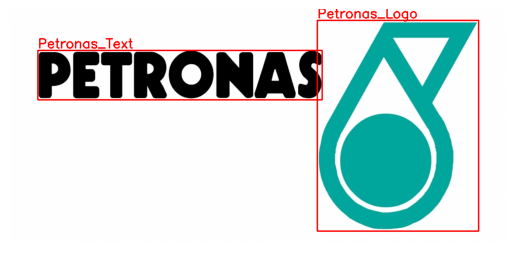

In [4]:
# print a test annotation
img_id = 0

# take the entry for the relevant image id
test_img = images[images['id']==img_id]

# load image
path = f"data/Label_Studio_Output/images/{os.path.basename(test_img['file_name'][0])}"
image = cv2.imread(path)

# ensure we are using the correct colour spectrum when displaying
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# overlay relevant bounding boxes
relevant_annots = annots[annots['image_id']==img_id]
for index, tag in relevant_annots.iterrows():
    # display bbox
    cv2.rectangle(
            image, 
            (int(tag.xmin), int(tag.ymin)), (int(tag.xmax), int(tag.ymax)),
            (255, 0, 0), 2
        )
    
    # display text label
    text = obtain_bbox_label(labels, tag)
    cv2.putText(
        image, text, (tag.xmin, tag.ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 
        (255,0,0), 2
        )

# display
plt.imshow(image)
plt.axis('off')
plt.show()

### Convert Annotation Format

This project makes use of Ultralytics' YOLOv5 model architecture (https://github.com/ultralytics/yolov5) for the purpose of logo detection. Therefore it is worth noting that, while the COCO json format I chose for my Label Studio export is convenient as it ensures all annotation data is contained in a single file, it is not the correct format for training the YOLO model architecture. 

Before we can begin to think about training the YOLO model, we need to first convert the COCO json format annotations to suitable YOLO format text files.

In [5]:
# define output dir (creating it if doesnt exist)
output_folder = 'data/Label_Studio_Output/yolo_annotations'
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)

# convert COCO to Yolo format
for _, image in images.iterrows():

    # extract COCO annotations to Yolo format
    image_dict = coco_to_dict(image, annots)
    file_name, file_txt = dict_to_yolo(image_dict)

    # save the file
    with open(os.path.join(output_folder, file_name), 'w') as f:
        for entry in file_txt:
            f.write(f"{entry}\n")

### Split Dataset

Now we have the correct format, we need to split the 50 images in to train, validate, and test sets. We will then copy these out to new relevant folders in preparation for training our model

In [6]:
base_path = 'data/Label_Studio_Output/'

image_list = [os.path.join(base_path, 'images', x) for x in os.listdir(os.path.join(base_path, 'images'))]
annot_list = [os.path.join(base_path, 'yolo_annotations', x) for x in os.listdir(os.path.join(base_path, 'yolo_annotations'))]

# to be sure the files are in the same order we sort
image_list.sort()
annot_list.sort()

# obtain the train and test 
img_train, img_test, annot_train, annot_test = train_test_split(image_list, annot_list, test_size = 0.2, random_state = 1)
img_val, img_test, annot_val, annot_test = train_test_split(img_test, annot_test, test_size = 0.5, random_state = 1)

In [7]:
copy_files(img_train, annot_train, 'train', 'data/petronas_logo_detection')
copy_files(img_val, annot_val, 'val', 'data/petronas_logo_detection')
copy_files(img_test, annot_test, 'test', 'data/petronas_logo_detection')

### Download Relevant Yolo

The next thing we want to do is to download the YOLOv5 repository and install all the requirements. 

```
git clone https://github.com/ultralytics/yolov5

pip install -r yolov5/requirements.txt
```

Note: this should be executed from the base directory of this project repor, such that the yolov5 repo shows at the same level alongside this project's README, and main.ipynb files and venv in the project folder structure

### Preparing YOLOv5 for training

Now that we have our data in the correct format and folder structure, we need to prepare for training our YOLO model. This involves creating yaml files to specify the label we wish our model to tag, as well as deciding on the model architecture and size. 

1) create a yaml file in "yolov5/data/", which specifies the detection task at hand. In the case of this project I created a file called "petronas_logo.yaml", which i populated with the following:
```
    path: ../data/petronas_logo_detection
    train: images/train
    val: images/val
    test: images/test 

    # number of classes
    nc: 2

    # class names
    names: 
      0: Petronas_Logo
      1: Petronas_Text
```

2) Next we need to decide on the model architecture we wish to use. Several standard model yamls have been provided in "yolov5/data/models/", where the yaml files specify the model architecture to use. Given that I intend to run the training locally, I opted for the smallest model, file "yolov5/data/models/yolov5s.yaml".

3) Lastly you need to decide on the hyperparameters to use when training your model. This covers conditions such as the model learning rate, warm up epochs, and level of augmentation (randomness and noise applied to the training data to improve generalisation). Again, given the fact i wish to train locally, I will opt for the low level augmentation file "yolov5/data/hyps/hyp.scratch-low.yaml". 

However, i recommend trialling different files if you wish to train for a professional application - being sure to train on GPU to reduce compute time when using more complex architectures and augmentations

We are now in a position where we can train our model

### Training YOLOv5

The YOLOv5 Python implementation has been designed such that training can be easily executed from the terminal command line (CLI). The overall structure is to execute the python train.py script, passing in various arguments such as the locations of your label data, model architecture and hyperparamter yamls, as well as other paramters such as batch size and number of epochs.

If you are not familiar with terms such as batch size or epochs, then i recommend reading the following: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

### Training on CPU
```
$ python yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 16 --epochs 200 --data petronas_logo.yaml --weights yolov5s.pt --workers 24 --name yolo_logo_dect
```

Notes: 
(1) for training on CPU you can perform distributed training by splitting the workload across mutliple processors, using the --workers command
(2) the --name command is that the outputted model training folder will be called - so name it something that is recognisable and specific to your project - in this case yolo_logo_detect


### Training on GPU

Training computer vision models on CPU is rarely effective of feasible, especially as the volume of images used in training and the complexity of the model architecture increases. Therefore, it is highly recommended to utilise any GPU chips that you may have available to you, be that in a cloud environment or locally.

In my case, I have a single NVIDIA GeForce RTX 3050 chip available in my local machine, which I will leverage for the purpose of trianing. However, before we can perform the training on our GPU resources, there are a few actions we need to address


#### Installing relevant GPU driver and dependencies
The folowing outlines the pre-requisite installations required (if not already installed), as the specific pytorch installation required

0) [Optional] If you don't already have your NVIDIA graphics card driver on your machine, you will have to download this first: https://www.nvidia.co.uk/Download/index.aspx?lang=en-uk

1) Install CUDA from here: https://developer.nvidia.com/cuda-downloads. In my case I installed CUDA 11.6 as it was one of the most recent stable distributions of CUDA that my graphics chip supports. However, it is worth noting that tensorflow only supports CUDA 11.2 at the latest: https://www.tensorflow.org/install/source#gpu, so if you work extensive in tensorflow asopposed to pytorch, you may wish to consider installing as slightly older version of CUDA

2) After installing, check installation by executing the following command in CLI
```
    $ nvcc --version
```
3) Following successful installation, you will need to install cuDNN: https://developer.nvidia.com/rdp/cudnn-download (make sure to download a compatible version with your CUDA)


#### Installing correct Pytorch compiliation
The version of Pytorch installed as standard from the Yolo requirements.txt does not support GPU. In order to address this we will need to install the correct version of torch. To do so, first we will need to uninstall all records of torch, torchvision, and torchaudio compilations installed from the YOLOv5 requirements.txt. You can do so by ensring that you are in this projects venv, before executing the following:
```
$ pip uninstall torch
$ pip uninstall torchvision
$ pip uninstall torchaudio
```

Following this, check the official Pytorch website to get the command for installing the version of Pytorch with GPU enabled:https://pytorch.org/get-started/locally/
Be sure to select the correct version of CUDA compatibility for your specific CUDA version. In my case the command was as follows
```
$ pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
```

Now we need to restart our Python Kernel, and reimport Pytorch, before executing a command to check if cuda distribution is available:
```
import torch
torch.cuda.is_available()
```
The kernel resposne should return "True" if everything is installed as expected.

In [10]:
torch.cuda.is_available()

True

In [11]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

#### Executing CLI for GPU training
Now that we have set up the relevant dependencies and installed a version of Pytorch with CUDA compatibility, we can execute our training using a slightly edited CLI command:
```
$ python yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 16 --epochs 200 --data petronas_logo.yaml --weights yolov5s.pt --workers 1 --name yolo_logo_detection
```

Notes: 
(1) As I train on a single GPU locally, I need to set workers == 1 to avoid errors being thrown for attempting to run distributed processing in parallel.
(2) Increasing the batch size will increase the volume of data that needs to be stored in temporary memory. As it happens, my local GPU is limited to4GB of memory, so increasing batch size past 16 results in memory issues. However, in possible itis best to increase bath size to result in improved training


We can alternatively execute training from the notebook (instead of the CLI) by using the following command (removing the comment at the tart of the line):

In [10]:
# !python yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 16 --epochs 200 --data petronas_logo.yaml --weights yolov5s.pt --workers 1 --name yolo_logo_detection

The outputs of the training can be found in the folder: "yolov5/data/runs/train/yolo_logo_detection/". In here are print outs of the training metrics over each epoch, as well as the weights of the trained model - saved in the "weights" folder.

Two different sets of weights are saved - the weights from the final epoch of training ("last.pt"), and the weights that performed best against the validation set ("best.pt").

We can now use the "best.pt" weights to detect logos in new images

### Run Detection

There are two main ways to run inference on new images: either from the python kernel, or from the CLI

First, using Python:

In [ ]:
# load the custom trained model weights we have just trained
model = torch.hub.load('ultralytics/yolov5', 'custom', 'yolov5/runs/train/yolo_logo_detection/weights/best.pt')

# select an example image from our test images
img_path = 'data/petronas_logo_detection/images/test/f096ae96-petronas_14.png'

# run inference
results = model(img_path)

In [60]:
# print the results
results.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,789.072449,520.634521,852.689331,604.01947,0.902799,0,Petronas_Logo


From the above example, we can see how to return the class of the object detected, and the location of the bboxes. We can then use this as required in the python environment to save the bbox coordinates, and/or plot them on the images for display.


However, the folks over at Ultralytics have done much of the heavy lifting for us, and enable us to do bulk inference, simply from the CLI:
```
!python yolov5/detect.py --source data/petronas_logo_detection/images/test/ --weights yolov5/runs/train/yolo_logo_detection/weights/best.pt --conf 0.3 --name yolo_logo_detection --save-txt
```

Which will output the results (both annotated images, and text files with bbox label data) to the followin folder "yolov5/runs/detect/yolo_logo_detection/"

### Detection on video frames

Now that we have trained a model, and tested logo deection on our test images, we are in a position to put it into practice. For the purpose of this project I will extract frames from a Forumla 1 videa online (in this case youtube) and run inference on the individual frames to detect the presence of the Petronas branding.


#### Download a video from Youtube

In [14]:
# create output path
save_path = 'data/videos'
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# specify videa url for download and downlaoded file name
youtube_url = 'https://www.youtube.com/watch?v=zc3JYvvmXxw'
download_name = "formula1_test"

# execute the download
#ydl_opts = {'outtmpl': f'{save_path}/%(title)s.%(ext)s',}
ydl_opts = {'outtmpl': f'{save_path}/{download_name}.%(ext)s',}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download([youtube_url])

[youtube] zc3JYvvmXxw: Downloading webpage
[download] Destination: data\videos\formula1_test.mp4
[download] 100% of 8.00MiB in 01:39                  


The resultant file has been downloaded as follows: "data/videos/formula1_test.mp4"

### Cut download to frames

Now we can use the openCV package to cut the downloaded video into frames. 

Note: in order to limit the number of frames on which we will run inference as part of this project, I set a limit of the first 200 frames (but the below code can be easily edited to remove if you wish to analyse a full video) 

In [ ]:
# specify source of mp4 file
source_file = os.path.join(save_path, download_name + ".mp4")

# define the output path
output_path = os.path.join(save_path, "frames")
if not os.path.isdir(output_path):
    os.makedirs(output_path)

# execute slice to frames
vidcap = cv2.VideoCapture(source_file)
success,image = vidcap.read()
count = 0
max_frames = 200    # the number of frames at which we stop slicing
while success and count < max_frames :
  cv2.imwrite(output_path + "/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

#### Run inference

Now that we have the frames extracted from the video, we can run inference over each of them
```
$ python yolov5/detect.py --source data/videos/frames/ --weights yolov5/runs/train/yolo_logo_detection/weights/best.pt --conf 0.3 --name yolo_logo_frame_detection --save-txt
```

In [ ]:
!python yolov5/detect.py --source data/videos/frames/ --weights yolov5/runs/train/yolo_logo_detection/weights/best.pt --conf 0.3 --name yolo_logo_frame_detection --save-txt

#### Examining output

The last thing we will do is to explore the results. We can first observe how the detection model has worked by visualising certain frames. However, more useful will be to observe how frequntly Petronas branding appers in the video, and what proportion (%) of each frame it appears in

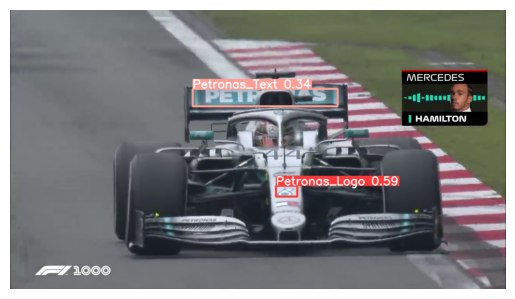

In [3]:
test_img = 'yolov5/runs/detect/yolo_logo_frame_detection/frame77.jpg'

image = cv2.imread(test_img)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)
plt.axis('off')
plt.show()

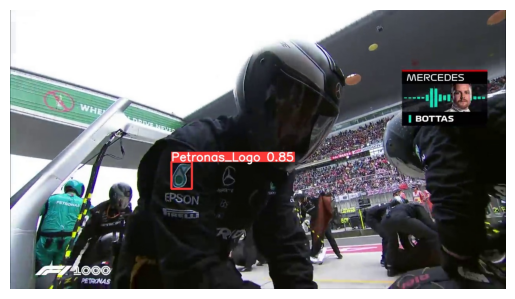

In [5]:
test_img = 'yolov5/runs/detect/yolo_logo_frame_detection/frame185.jpg'

image = cv2.imread(test_img)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)
plt.axis('off')
plt.show()

As can be seen from above, there are certain frames where the detection model appears to be working relatively well - with both the logo and branded text being detecting in some instances.

Now we can visualise the prominence of the Petronas branding by frame

In [8]:
output_folder = 'yolov5/runs/detect/yolo_logo_frame_detection'
frames = [f for f in os.listdir(output_folder) if os.path.isfile(os.path.join(output_folder, f))]
frames.sort()

In [48]:
label_map = {
    0: 'Petronas_Logo',
    1: 'Petronas_Text'
}

frame_coverage = pd.DataFrame()
for frame in frames:

    # obtain the frame number
    frame_number = int(frame.replace('frame', '').replace('.jpg', ''))

    # create path to the frame annotation text file (if it exists)
    annotation_file = os.path.join(output_folder, 'labels', frame.replace('.jpg', '.txt'))

    # check if there are annotations for this frame
    if os.path.isfile(annotation_file):

        # read the bbox data if it exists
        annotations = pd.read_csv(annotation_file, sep=' ', header=None)
        annotations.columns = ['label', 'x_centre', 'y_centre', 'width', 'height']

        # obtain the image size
        img = cv2.imread(os.path.join(output_folder, frame))
        img_height, img_width, img_depth = img.shape
        image_size = img_height * img_width

        # obtain the bbox size
        annotations['abs_width'] = round(annotations['width'] * img_width, 3)
        annotations['abs_height'] = round(annotations['height'] * img_height, 3)
        annotations['size'] = round(annotations['abs_width'] * annotations['abs_height'], 3)

        # obtain total area by label (Logo vs Text)
        coverage_df = annotations[['label', 'size']].groupby('label').sum() / image_size * 100
        coverage_df = coverage_df.reset_index()
        coverage_df['frame'] = frame_number

        # add data to master df
        frame_coverage = pd.concat([frame_coverage, coverage_df], axis=0)

    # if there are no annotations, we skip   
    else:
        continue

# update the mapping for label
frame_coverage['label'] = frame_coverage['label'].map(label_map)

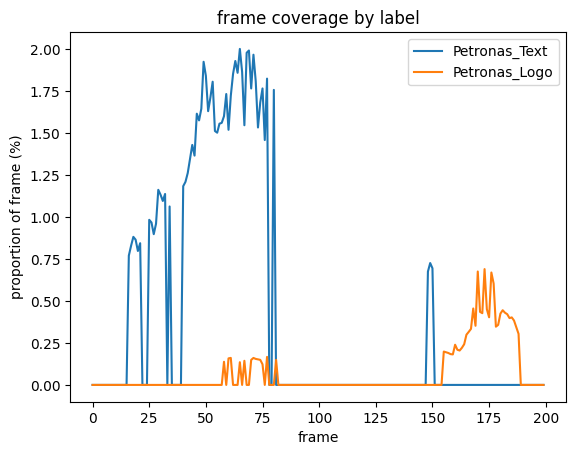

In [57]:
# plot the coverage
for lbl in frame_coverage['label'].unique():

    # cut to the relevant label
    frame_coverage_cut = frame_coverage[frame_coverage['label']==lbl]

    # create a master df with all frame numbers
    frame_count = list(range(0, len(frames)))
    master_frame_df = pd.DataFrame(columns = ['frame'], data = frame_count)

    # join on the annotation coverage
    master_frame_df = pd.merge(
        master_frame_df, frame_coverage_cut[['frame', 'size']], 
        on='frame', how='left'
    ).fillna(0)

    plt.plot(master_frame_df['frame'], master_frame_df['size'], label = lbl)

plt.xlabel('frame')
plt.ylabel('proportion of frame (%)')
plt.title('frame coverage by label')
plt.legend()
plt.show()

So what does this all mean? Well we could view the area under the chart as the overall exposure that the brand logo or text get in the video footage analysed. It is a function of the number of frames it appears in and the overall space it takes in the frame.

In terms of real-world applications, this could be applicable in our case to see which locations of the F1 car a logo gets the most exposure, for example. Or more gnerally speaking, if the analysis was replicated across different sports events, one could determine which which sports events provide brand sponsors with most exposure.

### Closing Comments

From the above chart we can see that there are some serious fluctuations in the detection of the Petronas logo. Having performed some manual analysis, it appears that there are several frames where the logo is visible, but was not correctly detected, meaning there is room for improvement in the model.

Going forward, to improve on the model I would address the following:

1) Training Data: The most significant improvement to make would be to increase the volume of training data significantly. Official YOLO documentation recommends >= 1500 images per class (compared to just 40 on which this model was trained). However, given the manual effort (or crowd-sourcing) required to obtain this, it was not achievable for this project - but would be the main area of improvement

2) Model Architecture: Secondly, I would look to explore more complex model architectures (with more neural network layers). There are several other architecture configurations provided by Ultralytics as standard, and I'd recommend training using larger models to see if it improves performance - but in my case i was limited by the GPU compute available to me

3) Training Parameters & Hyperparameter: Lastly i would recommend exploring greater levels of augmentation during training, as well as more computationally intensive training parameters - such as increased batch size and epochs. The greater levels of augmentation are likely to improve generalisation, while increased batch size will improve in-batch learning, while increase epochs will improve overall learning. However, once again I was limited in this example by the compute resources available

I would also recommend trialing different capabilities offered by YOLOv5, such as stream inference directly on videos or live feeds